# 2. Análise de histograma das imagens

## 2.1 Análise do ruido do cinza

Sabemos que há muito cinza nas pílulas. Será que ele atrapalha?

In [1]:
import cv2
import numpy as np
from skimage import img_as_ubyte

class Histogram(object):

    def histogram(self, image, mask_color=None):
        channels = [0, 1, 2]
        mask = None
        bins = [256, 256, 256]
        ranges = [0, 256, 0, 256, 0, 256]
        
        if mask_color is not None:
            mask = ~cv2.inRange(image, np.array(mask_color), np.array(mask_color))

        return cv2.calcHist([image], channels, mask, bins, ranges)

    def histogram_by_channel(self, image, mask_color=None):
        """
        Calculate histogram for all image channels 
        Util for print histogram by channel
        
        :param image: cv2 image
        :param list[int] mask_color: Color that will be ignored
        
        :return list[] histogram: list with 3 positions: b, r and g histograms
        """
        channels = cv2.split(image)
        
        if mask_color is None:
            mask_color = [None] * 3

        histograms = []
        for (channel, mask_channel_color) in zip(channels, mask_color):
            histograms.append(self.histogram_channel(channel, mask_channel_color))

        return histograms

    def histogram_channel(self, channel, mask_color=None):
        image = [channel]
        channel_one = [0]
        mask = None
        bins = [256]
        ranges = [0, 256]

        if mask_color is not None:
            mask = ~cv2.inRange(channel, np.array(mask_color), np.array(mask_color))

        return cv2.calcHist(image, channel_one, mask, bins, ranges)

Compare o histograma da pílula com e sem cinza. Na imagem sem cinza é aplicada uma máscara em todos os pixels cinzas $(118, 118, 118)$

In [2]:
import matplotlib.pyplot as plt

def histogram_brg(histogram, title="Color Histogram"):
    colors = ("b", "g", "r")

    plt.figure()
    plt.title(title)
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")

    for (channel, color) in zip(histogram, colors):
        plt.plot(channel, color=color)
        plt.xlim([0, 256])

    plt.show()

def histogram_compare_brg(histogram1, histogram2, title="Color Histogram"):
    colors = ("b", "g", "r")

    plt.figure()
    plt.title(title)
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")

    for (channel1, channel2, color) in zip(histogram1, histogram2, colors):
        plt.plot(channel1 - channel2, color=color)
        plt.xlim([0, 256])

    plt.show()

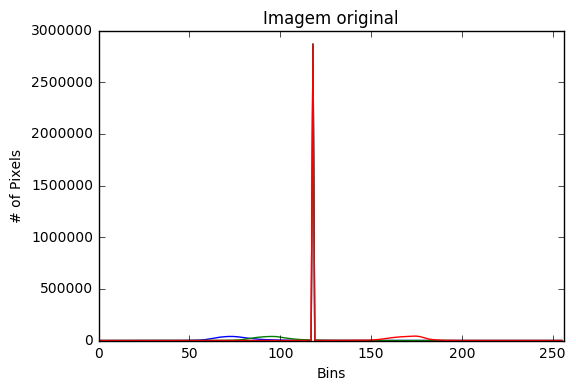

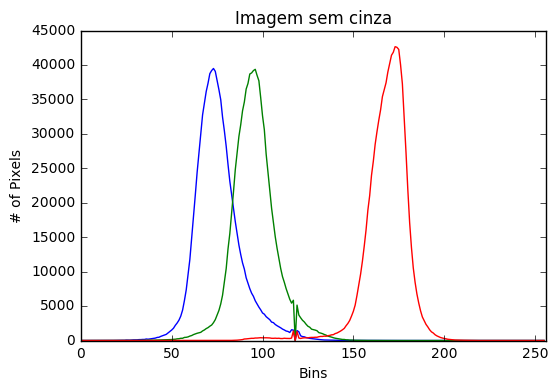

In [3]:
image = cv2.imread('PILL/00074-3020-11_PART_1_OF_1_CHAL10_SF_E01D703B.jpg')

histogram_calculator = Histogram()

histogram = histogram_calculator.histogram_by_channel(image)
histogram_brg(histogram, "Imagem original")

histogram = histogram_calculator.histogram_by_channel(image, mask_color=[118, 118, 118])
histogram_brg(histogram, "Imagem sem cinza")

## 2.2 Comparador de histograma

In [4]:
import pandas as pd

class HistogramComparator(object):
    
    def __init__(self):
        self.calculator = Histogram()

    def process(self, image_path, images_path, method):
        """
        :param method: cv2.HISTCOMP_*
        """
        image = cv2.imread(image_path)

        data = []
        for path in images_path:
            image_compare = cv2.imread(path)
            comparation = self.compare(image, image_compare, method)

            data.append((path, comparation))
        
        return pd.DataFrame(data, columns=('path', 'histogram_compare'))

    def compare(self, image1, image2, method):
        histogram1 = self.calculator.histogram(image1)
        histogram2 = self.calculator.histogram(image2)

        return cv2.compareHist(histogram1.flatten(), histogram2.flatten(), method)

In [5]:
import glob

#comparador = cv2.HISTCMP_CORREL
#comparador = cv2.HISTCMP_BHATTACHARYYA
#comparador = cv2.HISTCMP_CHISQR
#comparador = cv2.HISTCMP_CHISQR_ALT
#comparador = cv2.HISTCMP_CORREL
#comparador = cv2.HISTCMP_HELLINGER
comparador = cv2.HISTCMP_INTERSECT
#comparador = cv2.HISTCMP_KL_DIV

image_path = 'PILL/00074-3020-11_PART_1_OF_1_CHAL10_SF_E01D703B.jpg'

result = HistogramComparator().process(image_path, glob.glob("PILL/*"), cv2.HISTCMP_INTERSECT)

In [6]:
result_ordered = result.sort_values(by='histogram_compare', ascending=False)
result_ordered.head()

,path,histogram_compare
91,PILL/00074-3020-11_PART_1_OF_1_CHAL10_SF_E01D7...,3840000.0
135,PILL/00074-3020-11_PART_1_OF_1_CHAL10_SB_E01D7...,3696217.0
164,PILL/00093-7287-89_PART_1_OF_1_CHAL10_SF_D22FE...,3189739.0
277,PILL/00093-7287-89_PART_1_OF_1_CHAL10_SB_D22FE...,3146579.0
154,PILL/00093-7156-56_PART_1_OF_1_CHAL10_SF_DF27E...,2946918.0


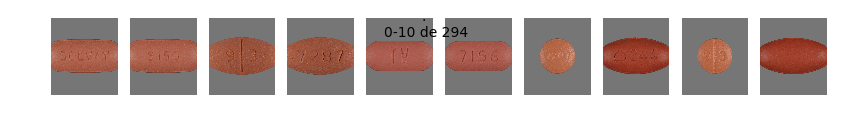

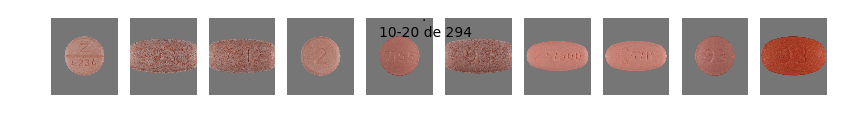

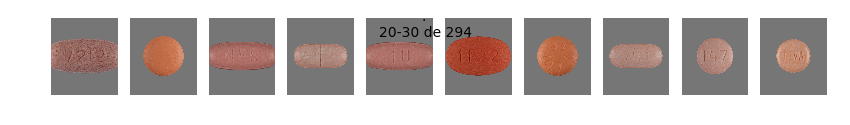

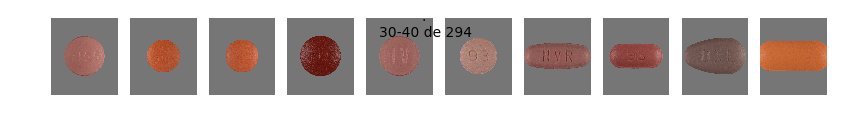

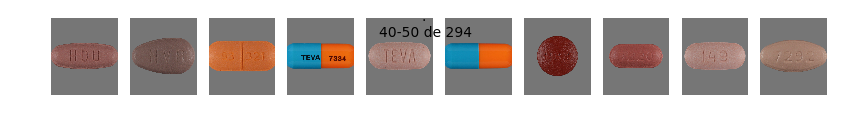

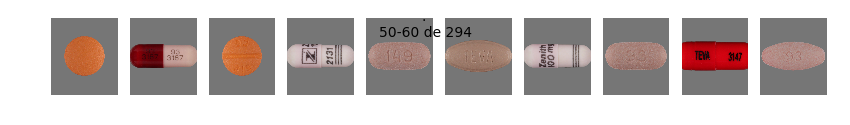

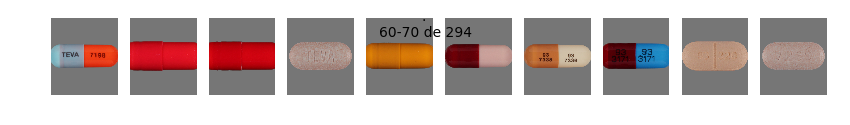

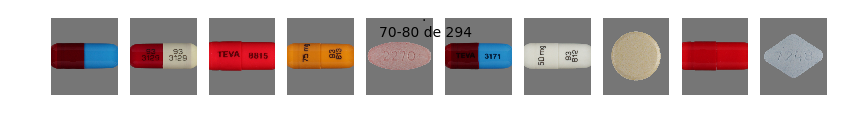

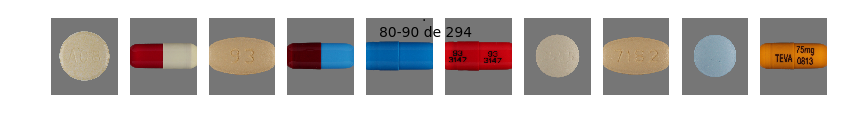

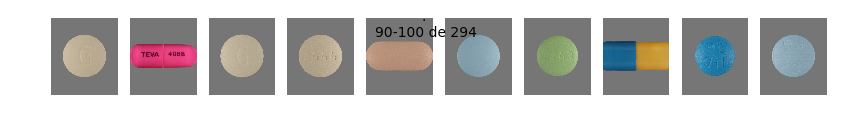

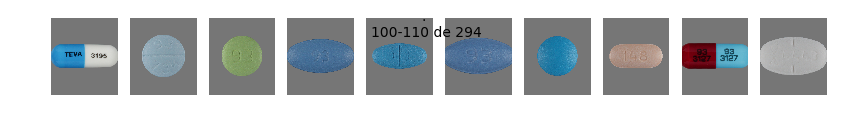

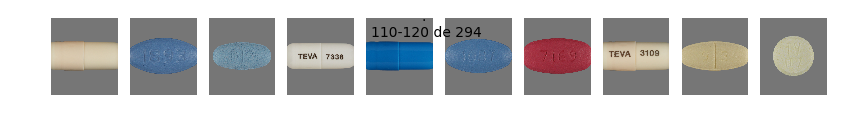

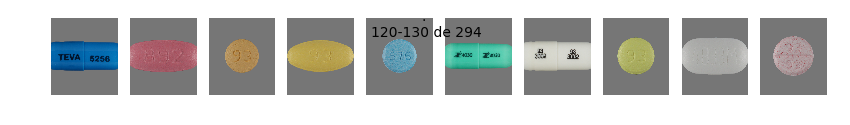

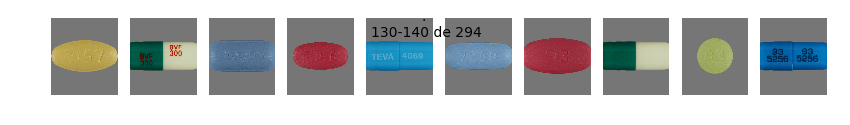

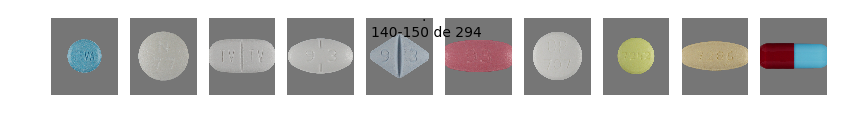

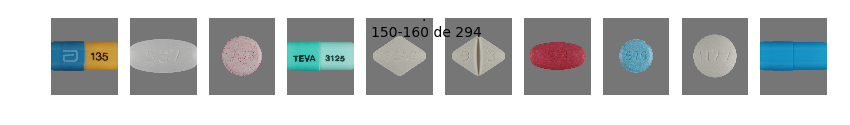

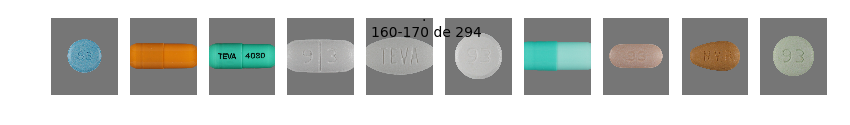

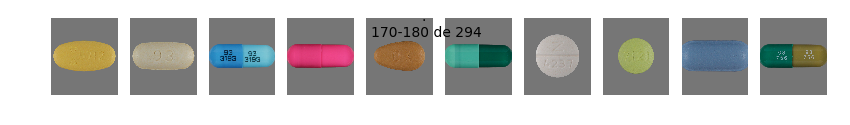

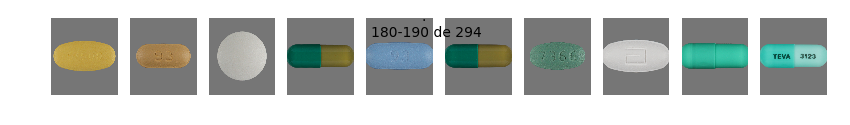

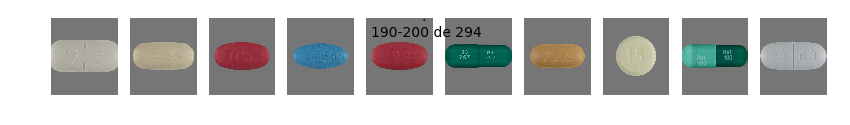

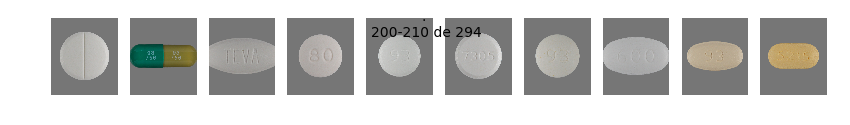

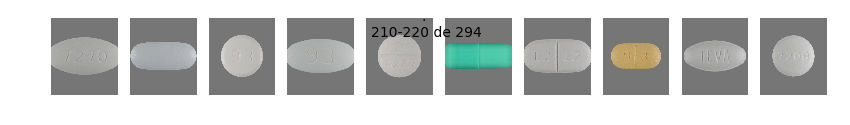

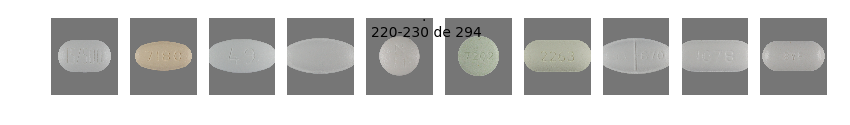

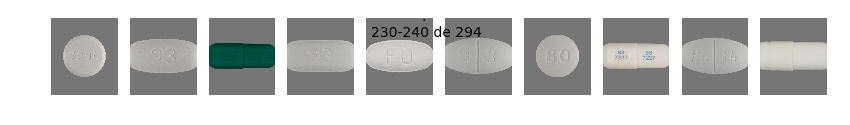

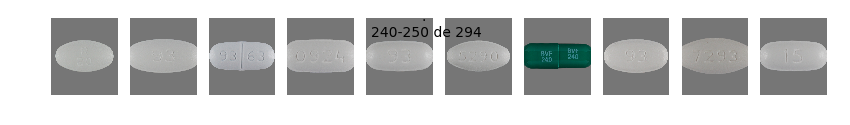

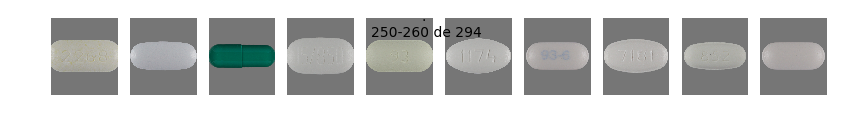

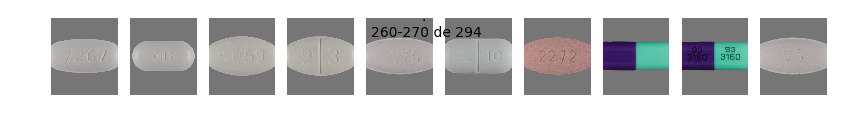

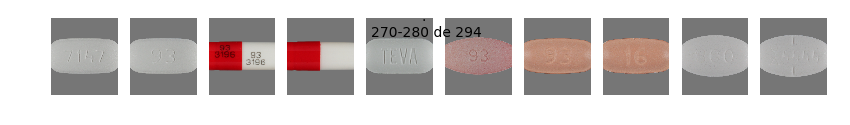

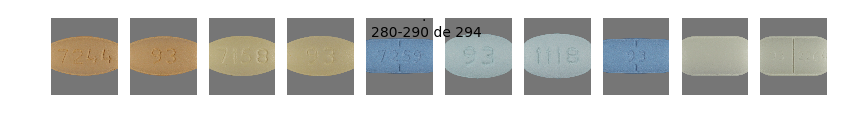

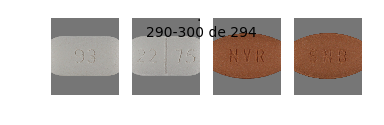

In [7]:
import math

def show_images_split(image_paths, title='', split=20):
    total = math.ceil(len(image_paths) / split)
    for x in range(0, len(image_paths), split):
        show_images(image_paths[x:x+split], title=title + '. \n{}-{} de {}'.format(x, x+split, len(image_paths)))

def show_images(image_paths, total_columns=10, title=None, split=20):
    total_columns = len(image_paths) if len(image_paths) < total_columns else total_columns

    total_lines = math.ceil(len(image_paths)/total_columns)
    f, subplots = plt.subplots(total_lines, total_columns, sharex='col', sharey='row', figsize=(total_columns, total_lines))
    f.suptitle(title)
    images = []

    for path, subplot in zip(image_paths, subplots.flat):
        image = cv2.imread(filename=path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        subplot.imshow(image)
        subplot.axis('off')

    plt.show()

show_images_split(result_ordered.path, split=10)

Os resultados na imagem testada foram bem legais, mas não foram perfeitos: os dois último resultados são bem parecidos com o primeiro, isto é, com a imagem que está comparando os histogramas. Talvez um borramento melhore ainda mais os resultados

/home/paulo/.local/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: iget(i) is deprecated. Please use .iloc[i] or .iat[i]
/home/paulo/.local/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: iget(i) is deprecated. Please use .iloc[i] or .iat[i]


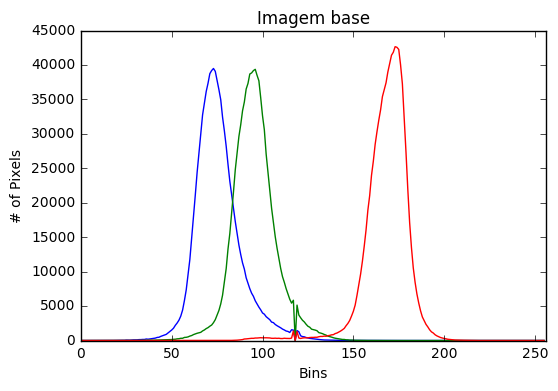

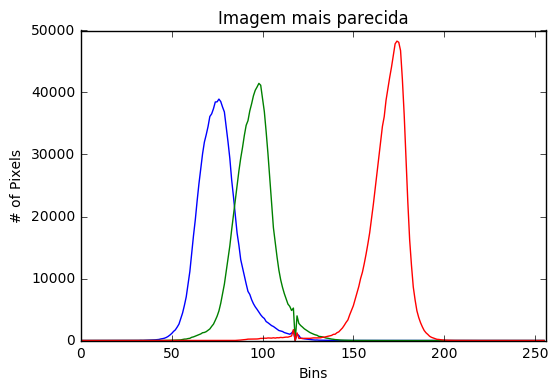

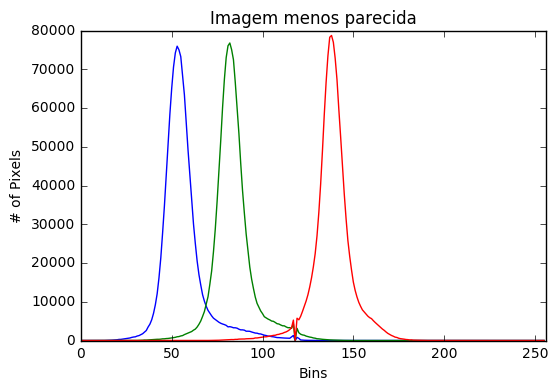

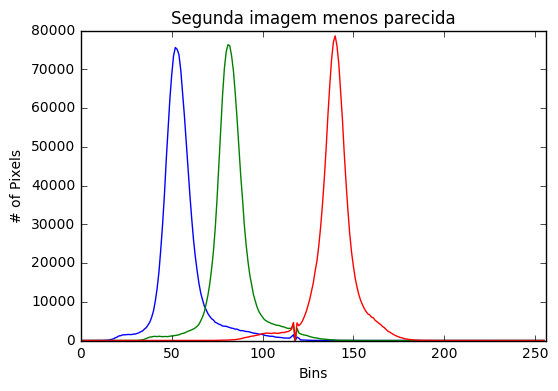

In [8]:
ordered = result_ordered.reset_index(drop=True)


imagem_base = cv2.imread(ordered.path[0])
imagem_mais_parecida = cv2.imread(ordered.path[1])
imagem_menos_parecida = cv2.imread(ordered.path.iget(-1))
imagem_menos_parecida_segunda = cv2.imread(ordered.path.iget(-2))


histogram_calculator = Histogram()

histogram = histogram_calculator.histogram_by_channel(imagem_base, mask_color=[118, 118, 118])
histogram_brg(histogram, "Imagem base")

histogram = histogram_calculator.histogram_by_channel(imagem_mais_parecida, mask_color=[118, 118, 118])
histogram_brg(histogram, "Imagem mais parecida")

histogram = histogram_calculator.histogram_by_channel(imagem_menos_parecida, mask_color=[118, 118, 118])
histogram_brg(histogram, "Imagem menos parecida")

histogram = histogram_calculator.histogram_by_channel(imagem_menos_parecida_segunda, mask_color=[118, 118, 118])
histogram_brg(histogram, "Segunda imagem menos parecida")

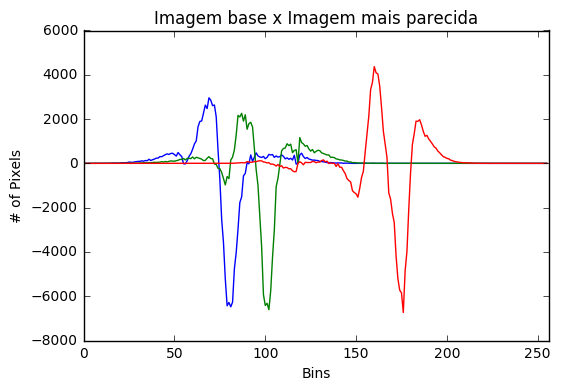

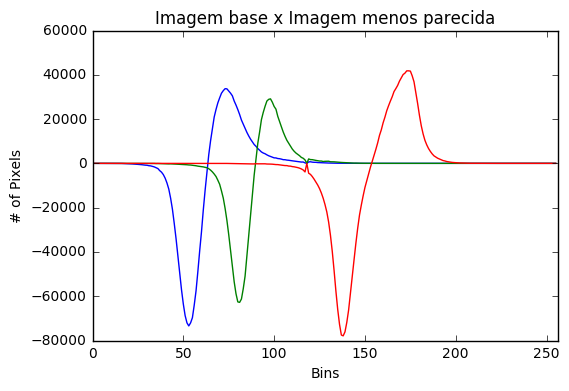

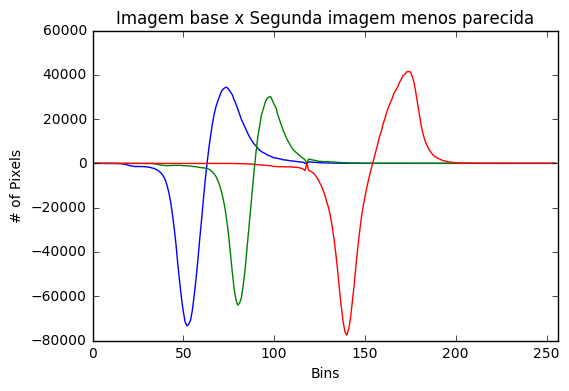

In [9]:
histogram_calculator = Histogram()


histogram_base = histogram_calculator.histogram_by_channel(imagem_base, mask_color=[118, 118, 118])

histogram = histogram_calculator.histogram_by_channel(imagem_mais_parecida, mask_color=[118, 118, 118])
histogram_compare_brg(histogram_base, histogram, "Imagem base x Imagem mais parecida")

histogram = histogram_calculator.histogram_by_channel(imagem_menos_parecida, mask_color=[118, 118, 118])
histogram_compare_brg(histogram_base, histogram, "Imagem base x Imagem menos parecida")

histogram = histogram_calculator.histogram_by_channel(imagem_menos_parecida_segunda, mask_color=[118, 118, 118])
histogram_compare_brg(histogram_base, histogram, "Imagem base x Segunda imagem menos parecida")
